# RLHF Fine-Tuning for Degradation Transformer

This notebook demonstrates how to fine-tune the pre-trained Degradation Transformer using Reinforcement Learning (REINFORCE) to improve long-term trajectory prediction.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
from torch.utils.data import DataLoader

## 1. Load Pre-trained Model
We load the model weights and configuration from the saved files.

In [2]:
import json
from safetensors.torch import load_model

# Load Config
with open('degradation_transformer_model_config.json', 'r') as f:
    config = json.load(f)

# Initialize Model Structure
model = DegradationTransformer(
    vocab_size=config['vocab_size'],
    context_window=config['context_window'],
    embedding_dim=config['embedding_dim'],
    num_heads=config['num_heads'],
    num_blocks=config['num_blocks']
)

# Load Weights
load_model(model, 'degradation_transformer_model.safetensors')
print("Model loaded successfully!")

Model loaded successfully!


## 2. Generate Data for RLHF
We generate a fresh batch of degradation episodes. We need long episodes to have enough future steps for the reward calculation.

In [3]:
# Parameters
CONTEXT_WINDOW = config['context_window']
FUTURE_WINDOW = 10  # Length of trajectory to predict and reward
EXRA_BUFFER = 10  # Extra buffer to avoid edge effects
EPISODE_LENGTH = CONTEXT_WINDOW + FUTURE_WINDOW + EXRA_BUFFER
EPISODES_PER_PARAM = 10

# Generate Data (all laws)
data = generate_episodes_from_all_models(episode_length=EPISODE_LENGTH, episodes_per_param=EPISODES_PER_PARAM)

#
# Shuffle indices
shuffled_indices = np.random.permutation(len(data))

# Apply shuffled indices
data = data[shuffled_indices]
data.shape

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:48: RuntimeWarning: overflow encountered in power
  return self.c * a ** (self.m/2)
/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:92: RuntimeWarning: overflow encountered in multiply
  fx = self.alfa * a * (1 - a / self.xmax)
/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:116: RuntimeWarning: invalid value encountered in power
  fx = self.beta * (a/self.alfa)**(1-self.k) * (1 - a/self.alfa)** (self.k -1)


(2708, 60)

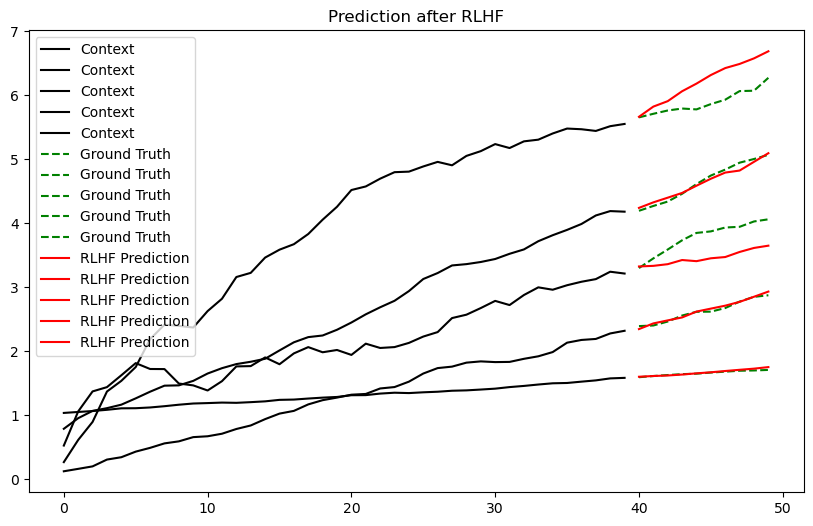

In [4]:
learner1 = Learner(model, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])
# Pick a random test sample
test_idx = np.random.randint(0, data.shape[0], size=5)
x_context = data[test_idx, :CONTEXT_WINDOW]
y_true = data[test_idx, CONTEXT_WINDOW:CONTEXT_WINDOW+FUTURE_WINDOW]

# Predict
y_pred,log_probs = learner1.predict(x_context, num_periods=FUTURE_WINDOW, temperature=0) # Greedy for eval

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(CONTEXT_WINDOW), x_context.T, 'k-', label='Context')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_true.T, 'g--', label='Ground Truth')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_pred.T, 'r-', label='RLHF Prediction')
plt.legend()
plt.title("Prediction after RLHF")
plt.show()


In [5]:
y_pred9,log_probs9,tokens9 = learner1.predict(x_context, num_periods=FUTURE_WINDOW, temperature=1, grad=True, return_tensor=True) # Greedy for eval
trajectory_log_probs = torch.stack(log_probs9, dim=1).sum(dim=1)

In [6]:
tokens9

tensor([[793, 788, 791, 782, 772, 784, 791, 797, 785, 791],
        [811, 766, 178, 750,  99, 158,  51, 780, 792,  97],
        [763, 825, 765, 783, 787, 785, 786, 791, 783, 792],
        [809, 790, 780, 801, 803, 781, 803, 791, 789, 793],
        [807, 785, 768, 775, 810, 794, 778, 785, 803, 840]], device='mps:0')

## 3. Prepare RL Dataset and Learner
We use the new `RLDataset` and `RLHFLearner`.

In [7]:
# Create Dataset
rl_dataset = RLDataset(data, CONTEXT_WINDOW, FUTURE_WINDOW, config['vocab_size'])
train_loader = DataLoader(rl_dataset, batch_size=32, shuffle=True)



In [8]:
len(rl_dataset), len(train_loader)

(27080, 847)

# 3.1 Tests for utils

In [21]:
# Initialize Learner
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Low learning rate for fine-tuning
reward_func = MSEReward()
cbs = [SaveModel()]  # Add any callbacks if needed
learner = RLHFLearner(
    model=model,
    optim=optimizer,
    reward_func=reward_func,
    train_loader=train_loader,
    cbs=cbs, # Add callbacks if needed
    device='mps' # or 'cuda'/'mps'
)

In [22]:
rn = next(iter(train_loader))
rn[0].shape, rn[1].shape, rn[2].shape, rn[3].shape

(torch.Size([32, 40]),
 torch.Size([32, 10]),
 torch.Size([32, 2, 1]),
 torch.Size([32, 40]))

In [23]:
rn[0].dim()

2

In [24]:
x_context=torch.randn([32, 40]).to('mps')
y_pred9,log_probs9,tokens9 = learner.predict(x_context, num_periods=FUTURE_WINDOW, temperature=1, grad=True, return_tensor=True) # Greedy for eval
trajectory_log_probs = torch.stack(log_probs9, dim=1)
# test get_log_probs(self, initial_context_float, sampled_tokens)
log_probs_test = learner.get_log_probs(x_context, tokens9)
trajectory_log_probs.shape, log_probs_test.shape
assert abs(trajectory_log_probs-log_probs_test).max().item()<1e-6

In [25]:
# test if these are close



In [26]:
trajectory_log_probs[0]

tensor([-1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07,
        -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07],
       device='mps:0', grad_fn=<SelectBackward0>)

In [27]:
log_probs_test[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='mps:0',
       grad_fn=<SelectBackward0>)

## 4. Run RLHF Training
We run the `fit_rl` method. We use a temperature > 0 to encourage exploration during training.

In [28]:
print("Starting RLHF Fine-tuning...")
learner.fit_rl_ppo(
    num_epochs=5,
    future_window=FUTURE_WINDOW,
    temperature=1.0, # Exploration
    baseline_momentum=0.9
)

Starting RLHF Fine-tuning...
Epoch 0, Batch 0, Avg advantage: -4.5237, Loss: 4.5237
Epoch 0, Batch 10, Avg advantage: 2.9127, Loss: -2.9127
Epoch 0, Batch 20, Avg advantage: 0.0070, Loss: -0.0070
Epoch 0, Batch 30, Avg advantage: -0.4653, Loss: 0.4653
Epoch 0, Batch 40, Avg advantage: 1.3470, Loss: -1.3470
Epoch 0, Batch 50, Avg advantage: -1.3754, Loss: 1.3754
Epoch 0, Batch 60, Avg advantage: 3.2581, Loss: -3.2581
Epoch 0, Batch 70, Avg advantage: 4.0806, Loss: -4.0806
Epoch 0, Batch 80, Avg advantage: 4.7016, Loss: -4.7016
Epoch 0, Batch 90, Avg advantage: 8.3571, Loss: -8.3571
Epoch 0, Batch 100, Avg advantage: 3.9748, Loss: -3.9748
Epoch 0 Finished. Mean advantage: -0.0470
Epoch 1, Batch 0, Avg advantage: 0.3880, Loss: -0.3880
Epoch 1, Batch 10, Avg advantage: 5.7729, Loss: -5.7729
Epoch 1, Batch 20, Avg advantage: -4.4915, Loss: 4.4915
Epoch 1, Batch 30, Avg advantage: -4.1948, Loss: 4.1948
Epoch 1, Batch 40, Avg advantage: -4.0406, Loss: 4.0406
Epoch 1, Batch 50, Avg advantage: 

## 5. Evaluate Results
Let's compare the model's predictions after fine-tuning.

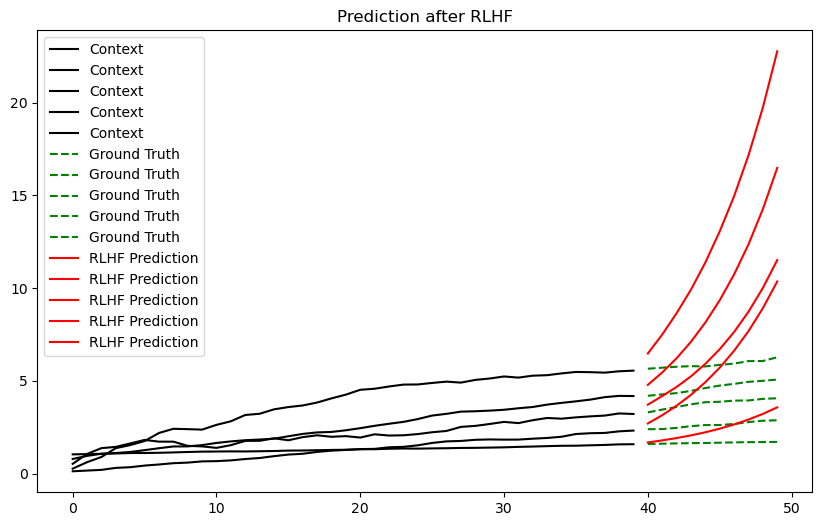

In [20]:
# Pick a random test sample

x_context = data[test_idx, :CONTEXT_WINDOW]
y_true = data[test_idx, CONTEXT_WINDOW:CONTEXT_WINDOW+FUTURE_WINDOW]
# Predict
y_pred,_ = learner.predict(x_context, num_periods=FUTURE_WINDOW, temperature=0.0) # Greedy for eval

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(CONTEXT_WINDOW), x_context.T, 'k-', label='Context')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_true.T, 'g--', label='Ground Truth')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_pred.T, 'r-', label='RLHF Prediction')
plt.legend()
plt.title("Prediction after RLHF")
plt.show()